In [1]:
import numpy as np
import matplotlib.pyplot as plt
import operator
import time
import timeit

In [2]:
# ################################################### Data to use ######################################################
train_data = np.array([(np.array(x), np.sin(x) + 0.1 * np.cos(10 * x)) for x in np.linspace(0, 2 * np.pi, 64)])
X = np.array([np.array(x) for x in np.linspace(0, 2 * np.pi, 16, endpoint=False)])
x,y = (zip(*train_data))
# ################################################### Data to use ######################################################

In [3]:
def phi_n_of_x(n: int) -> np.ndarray:
    """
    Basis function factory. Allows for easy generation of \phi_n(x).
    :param n: Dimensionality of the basis function
    :return: \phi_n(x)
    """

    def phi_of_x(x):
        return np.array([x ** i for i in range(n)])

    return phi_of_x

In [4]:
def gp_prediction_a(data: np.ndarray, X: np.ndarray, phi: callable, sigma_n: float, Sigma_p: np.ndarray) \
        -> (np.ndarray, np.ndarray):
    """
    Implementation of 2.11
    :param data: Data on which the model is fit
    :param X: Data to predict the mean and variance
    :param phi: basis functions
    :param sigma_n: variance for points in data
    :param Sigma_p: covariance
    :return: mean and variance for all points in X
    """
    # TODO compute parts
    # Phi: (N,n) matrix, N is the feature space after phi is applied, n is the number of observations
    Phi = np.apply_along_axis(phi, 0, data[:, 0])
    # A: (N,N) matrix
    A = sigma_n ** -2 * Phi @ Phi.T + np.linalg.inv(Sigma_p)
    A_inv = np.linalg.inv(A)
    # y: n-dim vector
    y = data[:, 1]

    tmp1 = A_inv @ Phi @ y

    # for storing the results
    means = []
    variances = []
    # loop over all X
    for xs in X:
        # TODO compute mean and variance
        phi_star =  phi(xs).reshape((-1,1))
        mean = sigma_n ** -2 * phi_star.T @ tmp1
        means.append(mean)
        variance = phi_star.T @ A_inv @ phi_star
        variances.append(variance.flatten())

    return np.array(means), np.array(variances)

In [5]:
def gp_prediction_b(data: np.ndarray, X: np.ndarray, phi: callable, sigma_n: float, Sigma_p: np.ndarray) \
        -> (np.ndarray, np.ndarray):
    """
    Implementation of 2.12
    :param data: Data on which the model is fit
    :param X: Data to predict the mean and variance
    :param phi: basis functions
    :param sigma_n: variance for points in data
    :param Sigma_p: covariance
    :return: mean and variance for all points in X
    """
    # TODO compute parts
    Phi = np.apply_along_axis(phi, 0, data[:, 0])
    y = data[:, 1]
    
    temp2=Phi.T @ Sigma_p @ Phi
    #temp2= temp2 + sigma_n**2 *np.eye(64,64)
    temp2= temp2 + sigma_n**2 *np.eye(temp2.shape[-1])
    
    print(temp2.shape)
    temp2_inv = np.linalg.inv(temp2)
    # for storing the results
    means = []
    variances = []
    # loop over all X
    for xs in X:
        phi_star =  phi(xs).reshape((-1,1))
        mean = phi_star.T @ Sigma_p @ Phi @ temp2_inv @ y
        means.append(mean)
        variance = (phi_star.T @ Sigma_p @ phi_star) - phi_star.T @ Sigma_p @ Phi @ temp2_inv @ Phi.T @ Sigma_p @ phi_star
        variances.append(variance.flatten())        # TODO compute mean and variance

    return np.array(means), np.array(variances)



(64, 64)


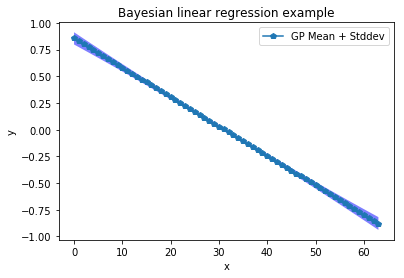

In [6]:
# ##################################################### Exercise (b)
# Plot model predictions for the bayesian linear regression:
num_features = 2
means, variances = gp_prediction_b(train_data, x, phi_n_of_x(num_features), 1.0, np.eye(num_features))

# TODO plot model prediction
x_axis = np.arange(len(means))
plt.plot(x_axis, means, 'p-', label='GP Mean + Stddev')
plt.fill(np.concatenate([x_axis, x_axis[::-1]]),
    np.concatenate([means - variances, (means + variances)[::-1]]),
    alpha=.5, fc='b', ec='None')

 
plt.title('Bayesian linear regression example')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.savefig('plot1.png')


(64, 64)
Equal means:  True
Equal variances:  True

Computing in feature dimension:  2
Computing in feature dimension:  4
Computing in feature dimension:  8
Computing in feature dimension:  16
Computing in feature dimension:  32
Computing in feature dimension:  64
Computing in feature dimension:  128
Computing in feature dimension:  256
Computing in feature dimension:  512
Computing in feature dimension:  1024
Computing in feature dimension:  2048
Computing in feature dimension:  4096


C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


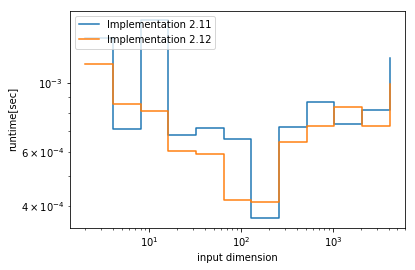

In [7]:
# ##################################################### Exercise (c)
# compare the predictions
mean1, var1 = gp_prediction_a(train_data, X, phi_n_of_x(num_features), 1.0, np.eye(num_features))
mean2, var2 = gp_prediction_b(train_data, X, phi_n_of_x(num_features), 1.0, np.eye(num_features))
# TODO decide if mean and variance are equal


print('Equal means: ', np.allclose(mean1,mean2))
print('Equal variances: ',np.allclose(var1,var2))
print()

# plot the computation time
tsa = []
tsb = []
dimensions = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
for n in dimensions:
    print('Computing in feature dimension: ', n)
    I_n = np.eye(n)        # setup Identity of dimensionality n
    phi_n = phi_n_of_x(n)  # get basis functions

    # TODO measure time to compute for implementation A 
    time_start = time.clock()
    mean1, var1 = gp_prediction_a(train_data, X, phi_n_of_x(num_features), 1.0, np.eye(num_features))
    time_elapsed = (time.clock() - time_start)
    tsa.append(time_elapsed)
    # TODO measure time to compute for implementation B
    time_start = time.clock()
    mean1, var1 = gp_prediction_a(train_data, X, phi_n_of_x(num_features), 1.0, np.eye(num_features))
    time_elapsed = (time.clock() - time_start)
    tsb.append(time_elapsed)
    
    
    
    
    

plt.figure()
plt.loglog(dimensions, tsa, label='Implementation 2.11', drawstyle='steps-post')
plt.loglog(dimensions, tsb, label='Implementation 2.12', drawstyle='steps-post')
plt.xlabel('input dimension')
plt.ylabel('runtime[sec]')
plt.legend(loc=2)

# plt.savefig('plot2.pdf')
plt.show()


(64, 64)
Equal means:  True
Equal variances:  True

Computing in feature dimension:  2
(64, 64)
Computing in feature dimension:  4
(64, 64)
Computing in feature dimension:  8
(64, 64)
Computing in feature dimension:  16
(64, 64)
Computing in feature dimension:  32
(64, 64)
Computing in feature dimension:  64
(64, 64)
Computing in feature dimension:  128
(64, 64)
Computing in feature dimension:  256
(64, 64)
Computing in feature dimension:  512


C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in matmul
  app.launch_new_instance()
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in matmul
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in matmul
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in double_scalars
  if __name__ == '__main__':
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in matmul
  app.launch_new_instance()


(64, 64)
Computing in feature dimension:  1024


C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in matmul
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in matmul
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in matmul


(64, 64)
Computing in feature dimension:  2048
(64, 64)
Computing in feature dimension:  4096
(64, 64)
Computing in feature dimension:  2
(64, 64)
Computing in feature dimension:  4
(64, 64)
Computing in feature dimension:  8
(64, 64)
Computing in feature dimension:  16
(64, 64)
Computing in feature dimension:  32
(64, 64)
Computing in feature dimension:  64
(64, 64)
Computing in feature dimension:  128
(64, 64)
Computing in feature dimension:  256
(64, 64)
Computing in feature dimension:  512
(64, 64)
Computing in feature dimension:  1024
(64, 64)
Computing in feature dimension:  2048
(64, 64)
Computing in feature dimension:  4096
(64, 64)
Computing in feature dimension:  2
(64, 64)
Computing in feature dimension:  4
(64, 64)
Computing in feature dimension:  8
(64, 64)
Computing in feature dimension:  16
(64, 64)
Computing in feature dimension:  32
(64, 64)
Computing in feature dimension:  64
(64, 64)
Computing in feature dimension:  128
(64, 64)
Computing in feature dimension:  256
(

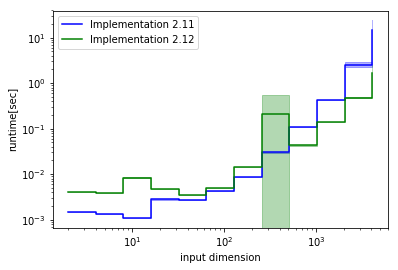

In [8]:
 ##################################################### Exercise (c)
# compare the predictions _ stefan's version
mean1, var1 = gp_prediction_a(train_data, X, phi_n_of_x(num_features), 1.0, np.eye(num_features))
mean2, var2 = gp_prediction_b(train_data, X, phi_n_of_x(num_features), 1.0, np.eye(num_features))
# TODO decide if mean and variance are equal
print('Equal means: ', np.allclose(mean1, mean2))
print('Equal variances: ', np.allclose(var1, var2))
print()

# plot the computation time
repetitions = 10
dimensions = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

tsa = np.ndarray((repetitions, len(dimensions)))
tsb = np.ndarray((repetitions, len(dimensions)))
for i in range(repetitions):
    for j, n in enumerate(dimensions):
        print('Computing in feature dimension: ', n)
        I_n = np.eye(n)        # setup Identity of dimensionality n
        phi_n = phi_n_of_x(n)  # get basis functions

        # TODO measure time to compute for implementation A
        tsa[i, j] = timeit.timeit(
            lambda: gp_prediction_a(train_data, X, phi_n, 1.0, I_n),
            number=1
        )
        # TODO measure time to compute for implementation B
        tsb[i, j] = timeit.timeit(
            lambda: gp_prediction_b(train_data, X, phi_n, 1.0, I_n),
            number=1
        )

tsa_mean = tsa.mean(axis=0)
tsa_var = tsa.var(axis=0)
tsb_mean = tsb.mean(axis=0)
tsb_var = tsb.var(axis=0)

plt.figure()
plt.loglog(dimensions, tsa_mean, label='Implementation 2.11', drawstyle='steps-post', c='b')
plt.fill_between(dimensions, tsa_mean - tsa_var, tsa_mean + tsa_var, alpha=.3, color='b', step='post')
plt.loglog(dimensions, tsb_mean, label='Implementation 2.12', drawstyle='steps-post', c='g')
plt.fill_between(dimensions, tsb_mean - tsb_var, tsb_mean + tsb_var, alpha=.3, color='g', step='post')

plt.xlabel('input dimension')
plt.ylabel('runtime[sec]')
plt.legend(loc=2)

plt.savefig('plot2.png')
plt.show()
